In [1]:
import json
import piezo
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
from protocols import utils
from catomatic.CatalogueBuilder import BuildCatalogue
from protocols.predict_2 import piezo_predict

This notebook examines proportions and effect sizes, and consequently investigates the differences in results of using different statistical tests and parameters.

We argue that the conservative workflow used in the WHOv1 and WHOv2, whereby relevant variants are missed in favour of high classification confidence, is not the right approach, and to some extent loses sight of application-driven optimisation.

We also want to actively classify susceptible mutations and therefore the core algorithm needs to identify benign variants. If this algorithm is effective at identifying relevant variants, there should be no need for a pre-processing step, nor a post-processing manual-intervention step. 

Therefore, our proposal is to adapt the Walker2015 algorithm to include an association test for evidence of heterogeneity. 

This aims to find a middleground between Walker2015 and WHOv2, where a statsitical test is used, but the workflow is simple and permissive.

However, to develop a method we need to examine R vs S counts for variants and map out phenotype distributions so we know what we're dealing with...



We are not interested in the proportions of resistance for variants that co-exist with other mutations that could induce resistance, as their distributions could be skewed by a third party  - we need to try and pry these causal relationships apart (we can't do this easily with frequentist statistics, but we can use deduction/elimination). 

A simple logistic regression model or perhaps even a bayesian mixed model would in theory be able to do this implicity, however the reason 2 problems:
 - our dataset contains a lot of singletons, which a linear model would really struggle with
 - we are trying to build on previous work, which uses the Definite Defectives algorithm, and so the mechanism used to isolate variants should mirror that which we are trying to adapt and use.

 The tricky thing is that to isolate mutations, we need to actually run a protocol (even though the protocol is what we're trying to develop) - the problem and solution are a little cyclical.

What we can do, however, is rather than run a full workflow with association test, we can instead call variants susceptible if they are homogenously S (similar to Walker2015) to unlock variants, and leave it there. This should pry variants apart without going too far, and should give us an idea of what the distributions look like.

## Data prep

This preperation is all explained in manuscript.ipynb

In [2]:
phenotypes_cryptic = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_CRYPTIC.csv.gz", index_col=0)
phenotypes_nicd = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_NICD.csv.gz", index_col=0)

mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz', index_col=0)

mutations["MUTATION"] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)
mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
)
mutations["FRS"] = mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)
cat_mutations = mutations[~mutations["IS_SYNONYMOUS"]].copy()

genomes = pd.read_csv("./data/GENOMES.csv.gz", index_col=0)

phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.METHOD_3.isin(['UKMYC5','UKMYC6'])]
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.QUALITY=='HIGH']

has_mgit = phenotypes_nicd[phenotypes_nicd.METHOD_CC=='WHO'].index

phenotypes_nicd = phenotypes_nicd[
    phenotypes_nicd.index.isin(has_mgit) & phenotypes_nicd.index.isin(genomes.index)
]
phenotypes_nicd.reset_index(inplace=True)
phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(utils.filter_multiple_phenos)
phenotypes_nicd.reset_index(drop=True, inplace=True)
phenotypes_nicd.set_index('UNIQUEID', inplace=True)

phenotypes = pd.concat([phenotypes_cryptic, phenotypes_nicd]) 
samples = phenotypes.join(genomes, how="inner")[["DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "METHOD_MIC"]]

all_cat = cat_mutations.join(samples, how='right')
all = mutations.join(samples, how='right')

with open('./wildcards/bdq_wildcards.json') as f:
    piezo_wildcards = json.load(f)


## Build a skeleton form of a catalogue

If we use an iterative method to find susceptible variants, we should be able to gather alot of evidence, which we can then examine.

In [3]:
samples = samples.reset_index()
cat_mutations = cat_mutations.reset_index()

# build catalogue at FRS 0.1 without phenotyping
catalogue = BuildCatalogue(
    samples=samples,
    mutations=cat_mutations,
    FRS=0.1,
    seed=["mmpL5@I948V", "mmpL5@T794I"],
    test=None,
    record_ids=True
).return_catalogue()

catalogue = {k: v for k, v in catalogue.items() if 'seeded' not in v['evid']}

catalogue

{'Rv0678@A101E': {'pred': 'S',
  'evid': ({'proportion': 0.0,
    'confidence': (0.0, 0.7934506856227626),
    'contingency': [[0, 1], [117, 6545]],
    'ids': ['site.02.subj.0006.lab.2014222013.iso.1']},)},
 'mmpL5@T606A': {'pred': 'S',
  'evid': ({'proportion': 0.0,
    'confidence': (0.0, 0.6576197724933469),
    'contingency': [[0, 2], [117, 6545]],
    'ids': ['site.02.subj.0013.lab.2014222055.iso.1',
     'site.02.subj.0616.lab.232059-15.iso.1']},)},
 'mmpL5@P180L': {'pred': 'S',
  'evid': ({'proportion': 0.0,
    'confidence': (4.8683609171202235e-17, 0.5614970317550455),
    'contingency': [[0, 3], [117, 6545]],
    'ids': ['site.02.subj.0027.lab.2014233008.iso.1',
     'site.02.subj.0789.lab.2013232254.iso.1',
     'site.02.subj.0898.lab.22A132.iso.1']},)},
 'mmpL5@S71P': {'pred': 'S',
  'evid': ({'proportion': 0.0,
    'confidence': (0.0, 0.4898908364545973),
    'contingency': [[0, 4], [117, 6545]],
    'ids': ['site.02.subj.0056.lab.22A006.iso.1',
     'site.02.subj.0059.la

## Plot proportions

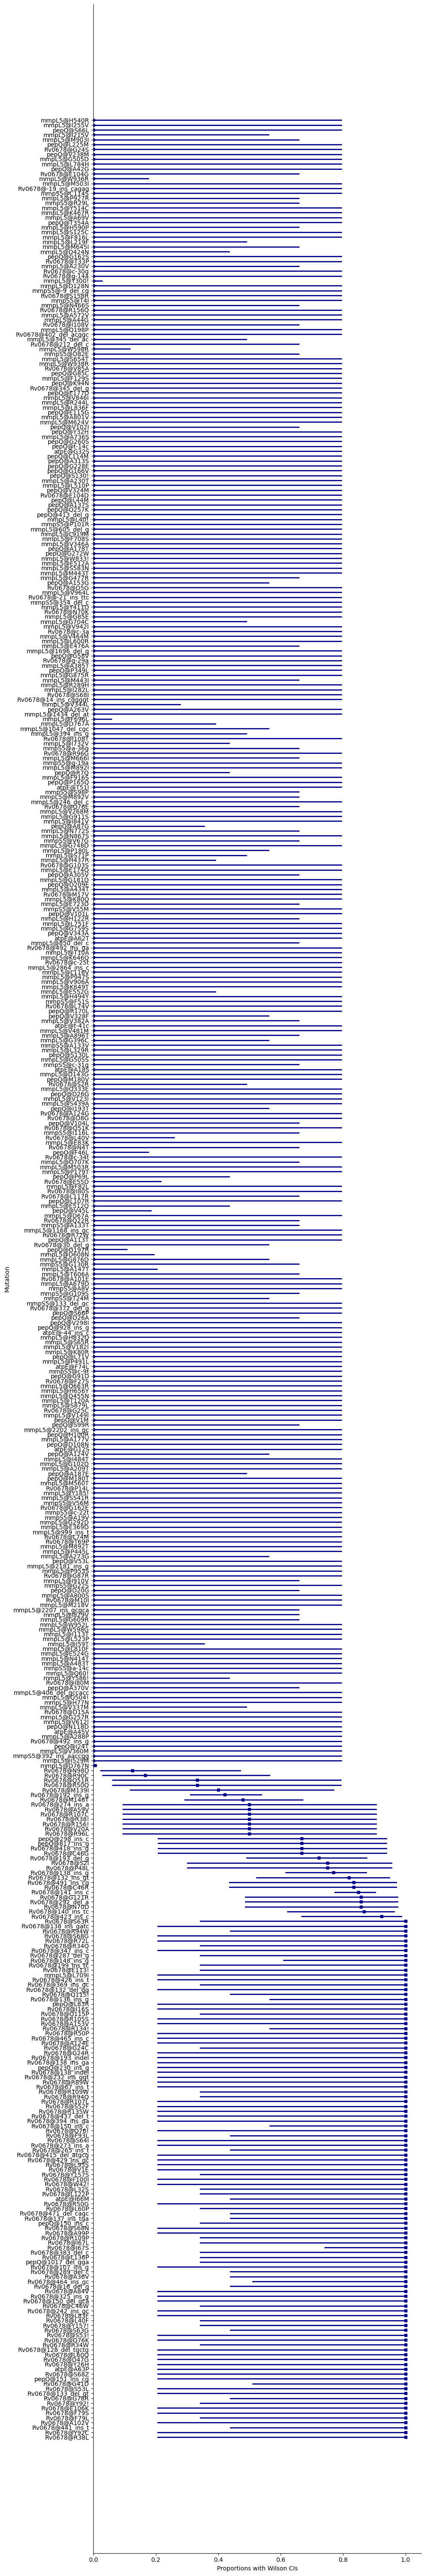

In [4]:
utils.plot_catalogue_proportions(catalogue, figsize=(10, 60))

Firslty, mmpL5 and mmpS5 all come out at with proportions = 0, which would suggest they're just adding noise - lets remove mmpL5 to try and clean up and simplify the picture:

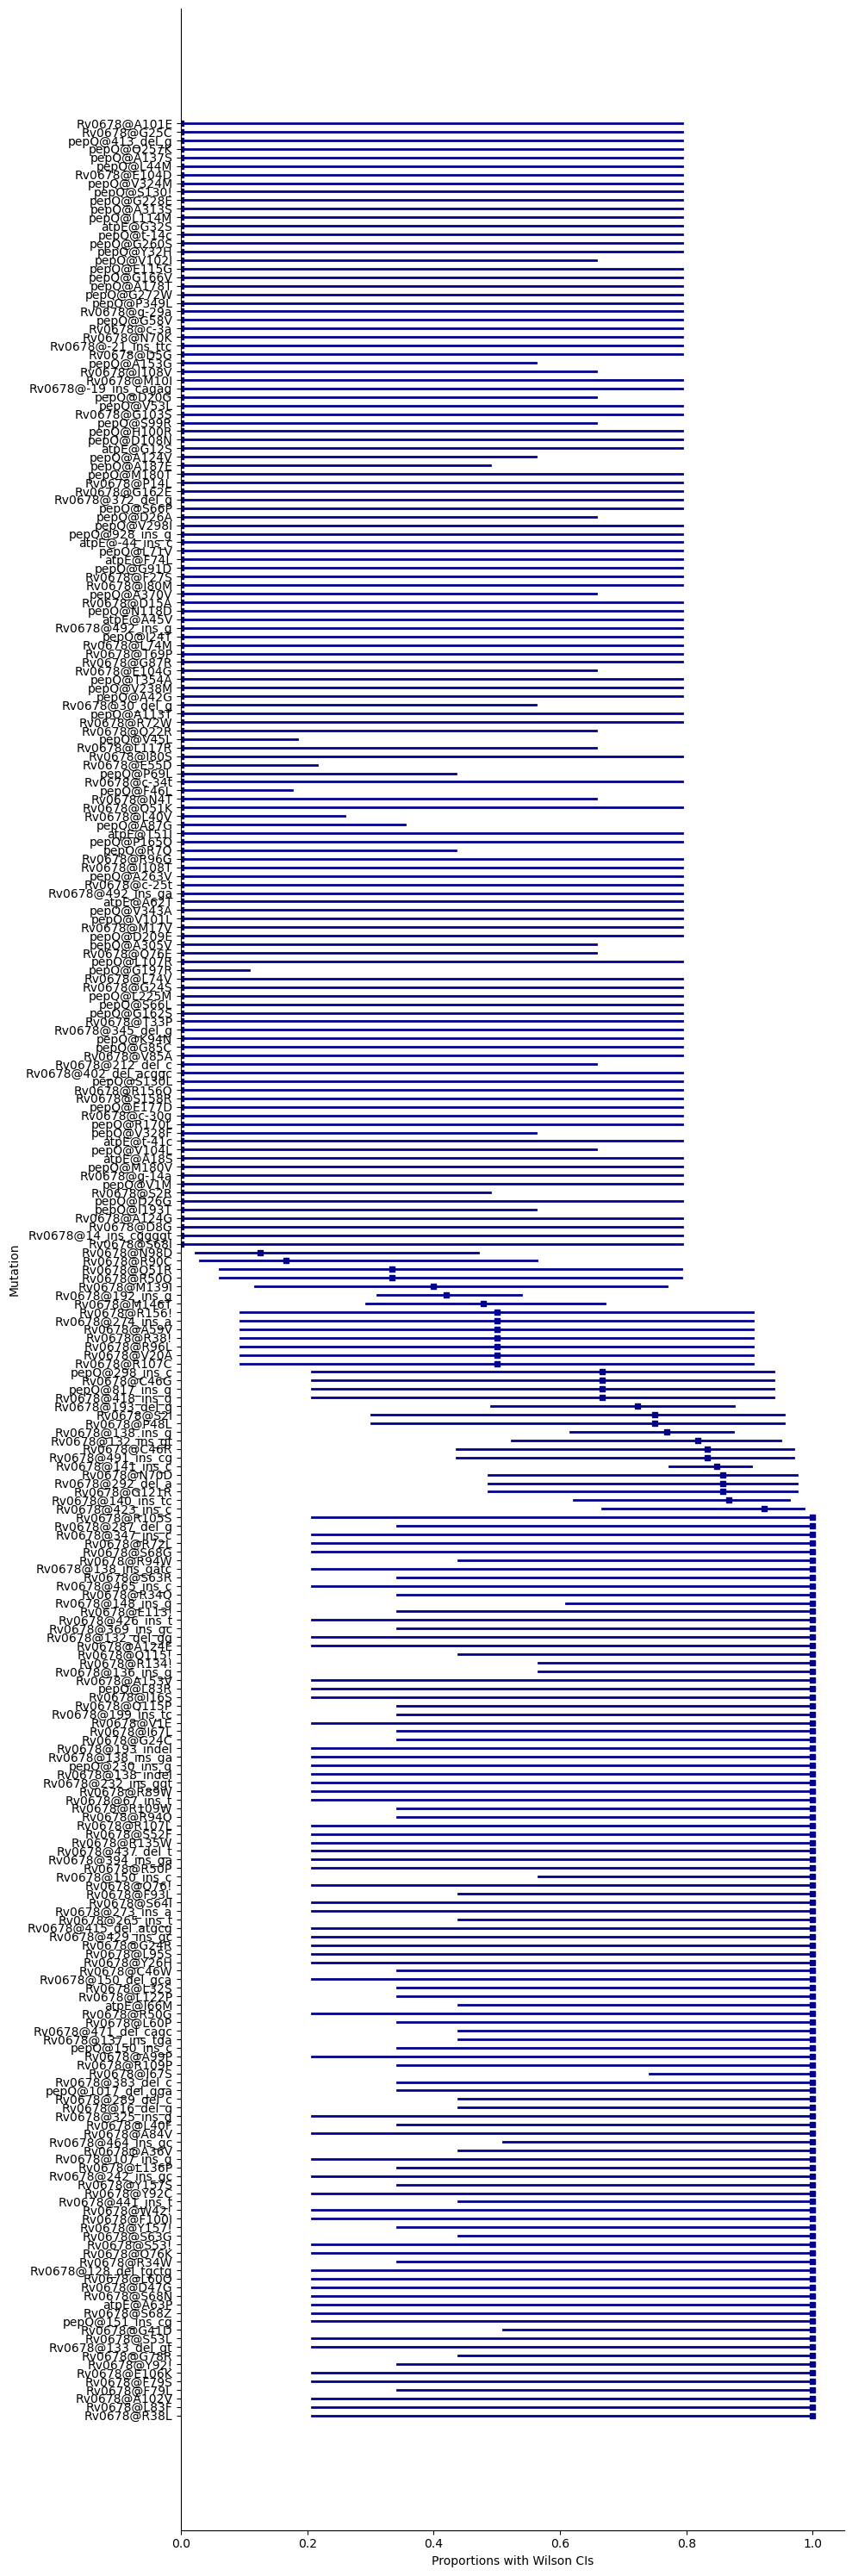

In [5]:
#remove mmpL5 and mmpS5
catalogue_no_mmpL5 = {k: v for k, v in catalogue.items() if k.split('@')[0] not in ['mmpL5', 'mmpS5']}

utils.plot_catalogue_proportions(catalogue_no_mmpL5, figsize=(10, 30))

The next observations, is that most of these confidence intervals are massive - these likely arise from singletons (and duplets) on either side. 



## Proportions vs backgrounds

We may want to filter these singletons out as they carry no statistical power. One way to implicitly do this would be to require statistical significance from an association test to phenotype variants. However, for analysis purposes we can just use a minimum count filter to clean them out.

We should also plot a background rate. If we are going to use a Fisher's test, the background rate needs to be calculated, which we can do from the contingency table:


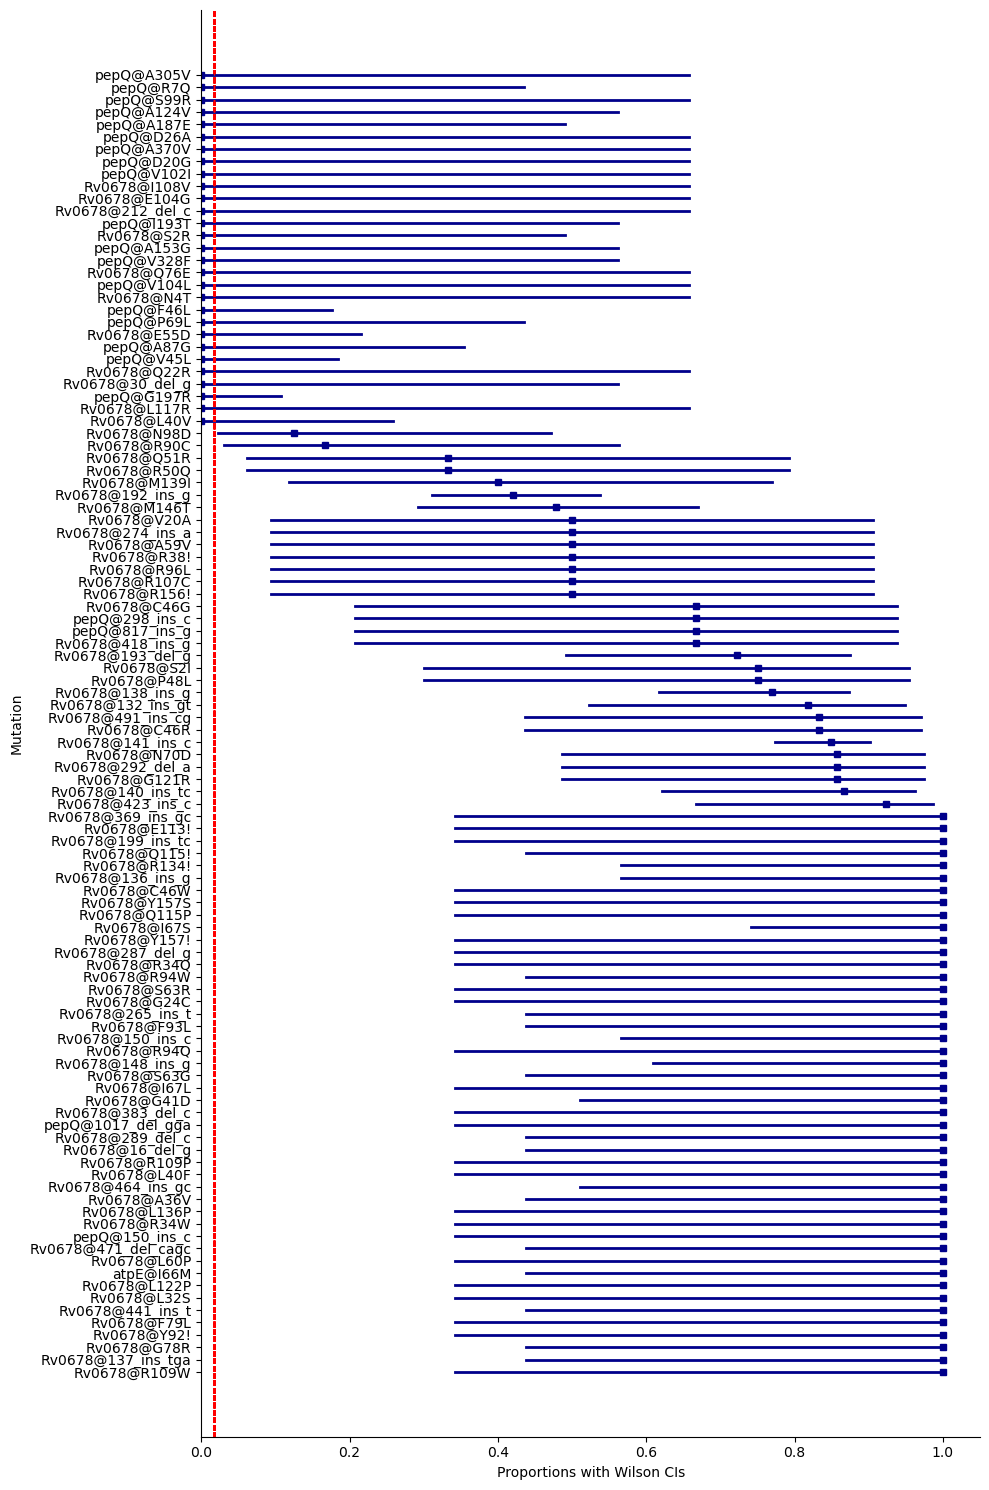

In [6]:
#filter out singletons from the catalogue
catalogue_no_mmpL5_singles = {
    k: v
    for k, v in catalogue_no_mmpL5.items()
    if (v["evid"][0]["contingency"][0][0] + v["evid"][0]["contingency"][0][1]) > 1
}

#calculate background rates
backgrounds = []
for k, v in catalogue.items():
    backgrounds.append(v['evid'][0]['contingency'][1][0]/(v['evid'][0]['contingency'][1][0]+v['evid'][0]['contingency'][1][1]))
#take the maximum background rate
background = np.max(backgrounds)

utils.plot_catalogue_proportions(catalogue_no_mmpL5_singles, background, figsize=(10, 15))

The calculated background rate from the solo contingnecy tables is tiny - ~2%...

The Fisher's test uses a contingency table, and this can only be justified if the backgrounds represent something meaningful.

Ideally, the background resistance rate would reflect:
 - sampling error
 - labelling error
 - unexplainable resistance (ie other genes or missing mechanisms)

Our backgrounds are defined as R or S phenotypes in the absence of that mutation or any mutations not yet classified as susceptible - which logically makes sense and should in theory cover the above points.

However, in reality our calculated backgrounds cannot be interpreted as we are combining 2 datasets. The first is much larger and was collected when BDQ was novel and clinical use was limited - its proportion of resistance is 0.78%. The second is much smaller was collected under a heavy sampling bias protocol, where BDQ resistance was sought after - 67% resistant. Therefore, the vast majority of resistant samples are contributed by the second dataset, but the first dataset swamps the background rate toward susceptible. 

It is therefore unsurprising that we see an extremeley low background BDQ resistance rate of around 2.0%, which is even lower than the assumed labelling error rate (and is partly due to our filtering out of low-quality phenotypes).

Another consequence of such a low background rate is that any heterogeneity, any at all, will likely be called resistance - as in this case, the proportion of resistance has to only be significantly greater than 2.5%...

Therefore, if backgrounds have limited meaning adn any heterogeneity effectively gets called resistant, there wouldn't appear to much point of using a Fisher's test.

It may be more sensible to assume and define a set background rate - perhaps one closer to the estimated sampling and labelling error rates.... Bacgkround = 0.10 seems reasonable...

Comparing against a fixed value would justify use of the Binomial Test.


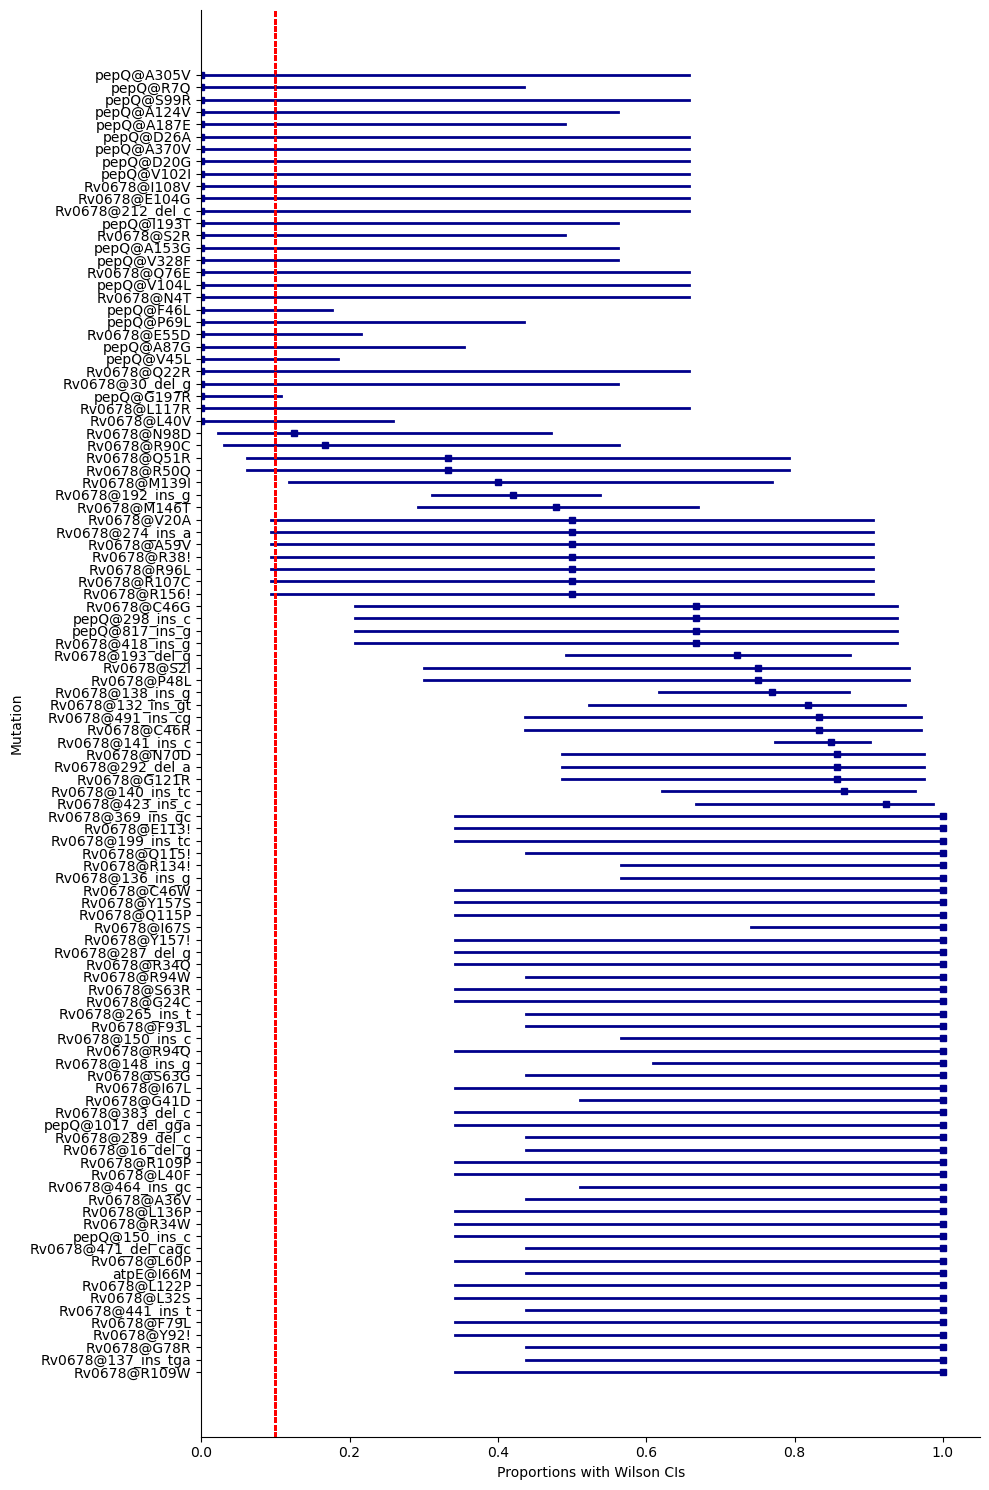

In [7]:

utils.plot_catalogue_proportions(catalogue_no_mmpL5_singles, 0.10, figsize=(10, 15))

Before we run any tests, lets investigate samples that will likely get p values greater than 0.05. Many of the zero proportion variants are failing the test becuase they dont have enough data

What's more interesting, though,  are the heterogenous variants...



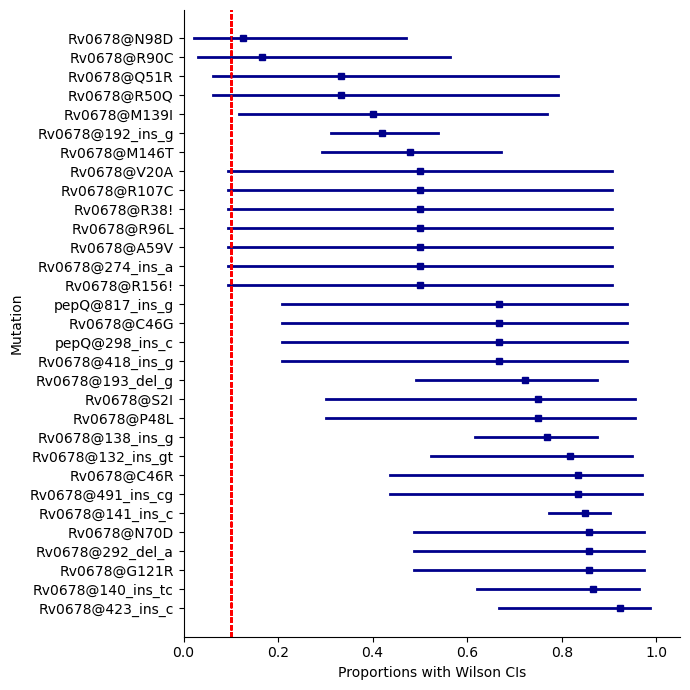

In [8]:
#filter out singletons from the catalogue
catalogue_no_mmpL5_heterogenous = {
    k: v
    for k, v in catalogue_no_mmpL5.items()
    if (v["evid"][0]["contingency"][0][0]  > 0) and (+ v["evid"][0]["contingency"][0][1] > 0)
}
utils.plot_catalogue_proportions(catalogue_no_mmpL5_heterogenous, 0.10, figsize=(7, 7))

In [9]:
#extract heterogenous mutations
non_zero, ids = {}, []
for k, v in catalogue_no_mmpL5_heterogenous.items():
    evid = v['evid'][0]
    non_zero[k] = {'R':evid['contingency'][0][0], 'S': evid['contingency'][0][1]}
    ids+=evid['ids']

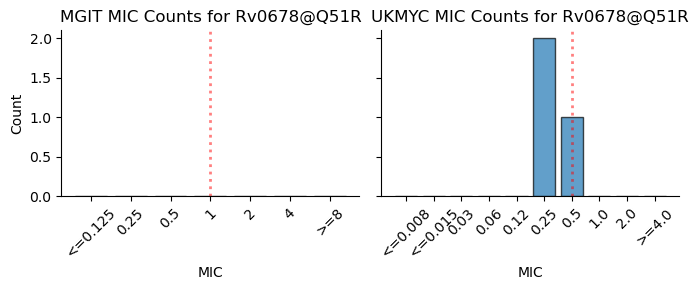

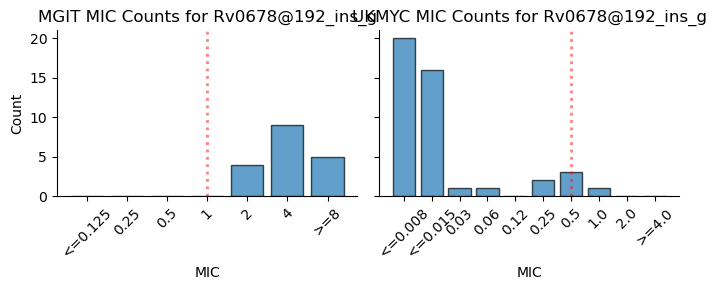

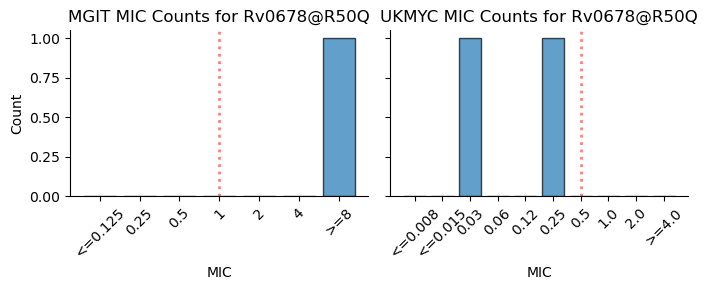

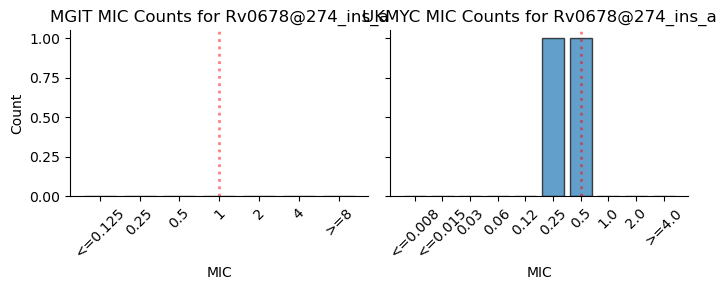

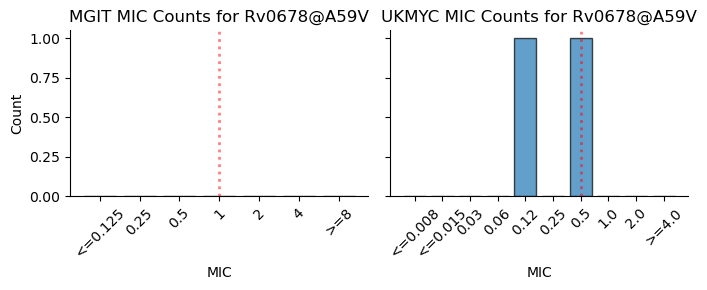

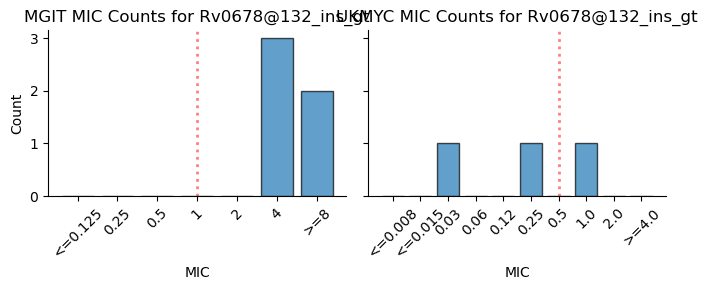

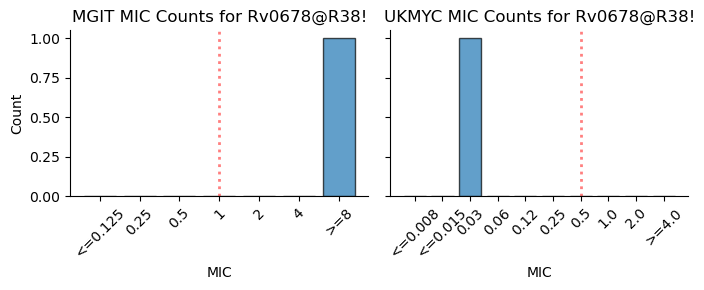

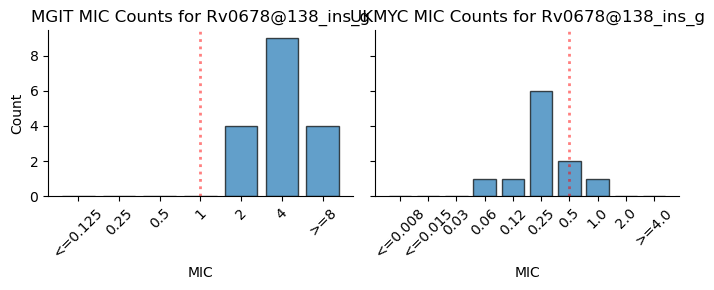

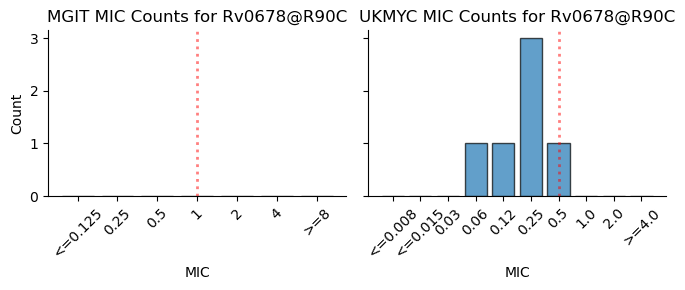

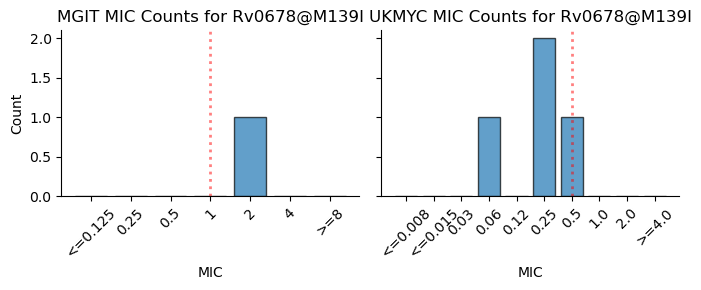

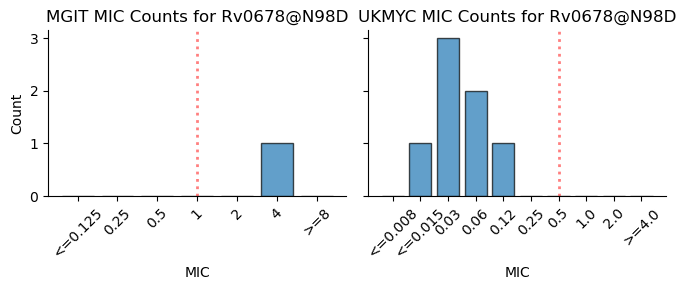

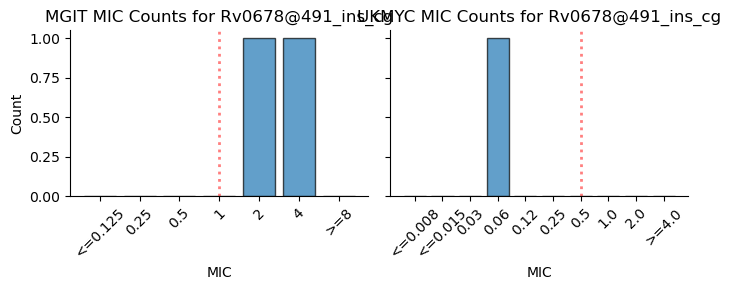

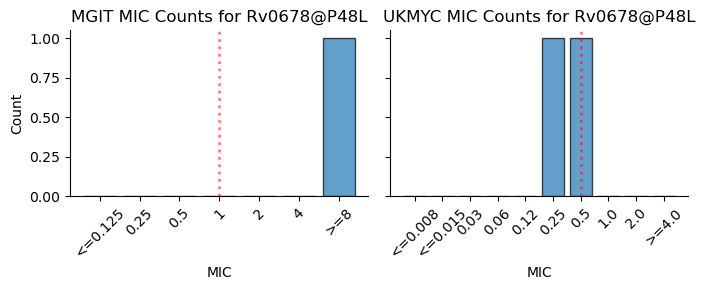

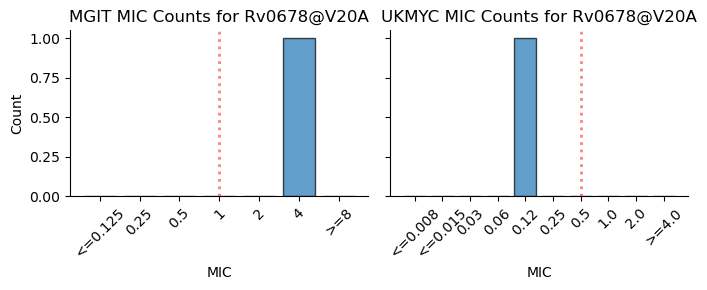

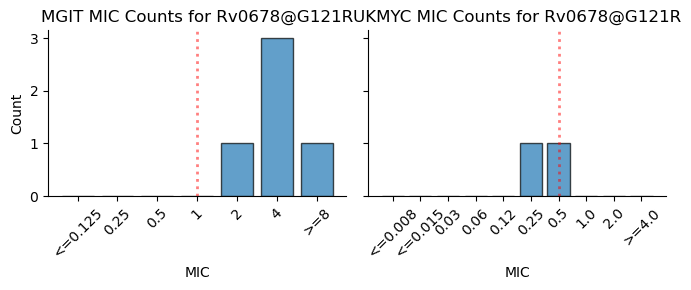

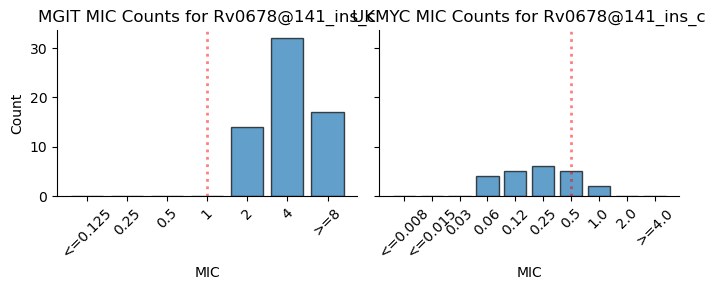

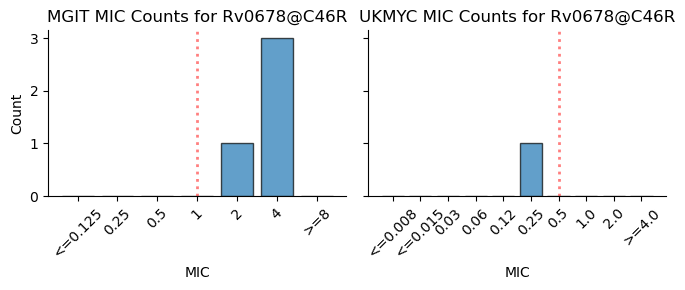

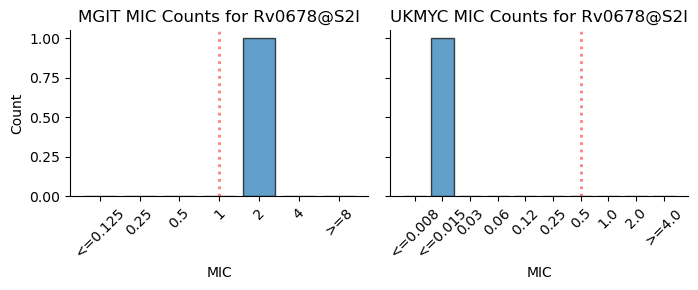

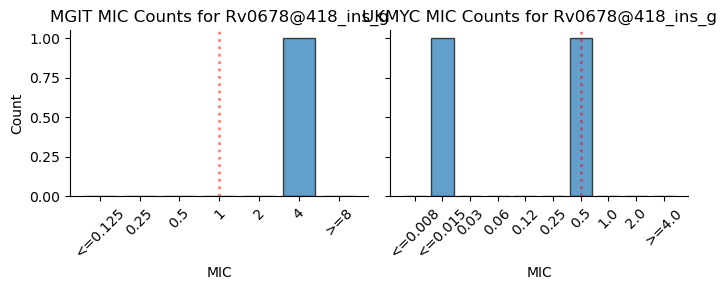

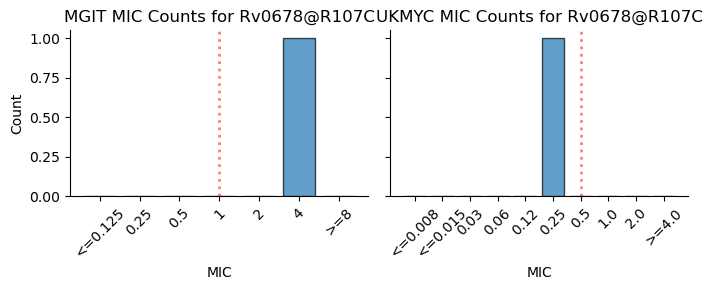

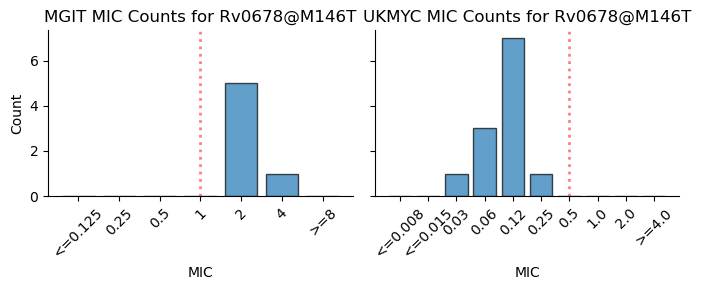

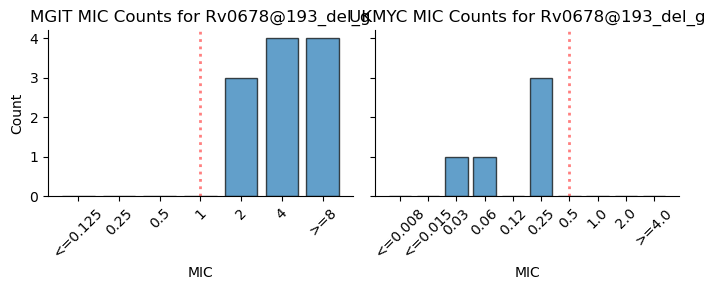

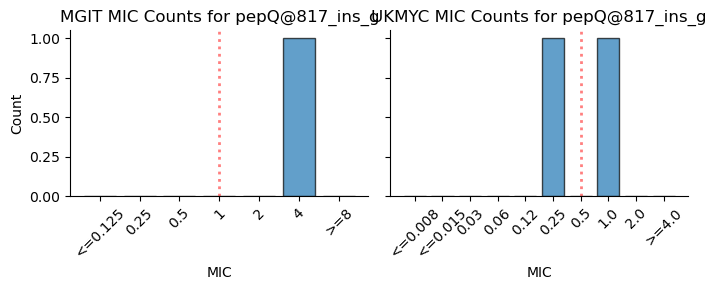

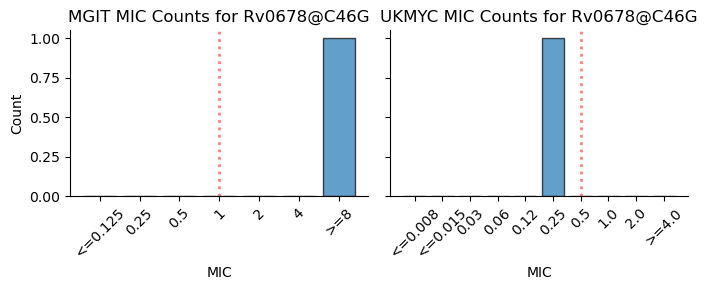

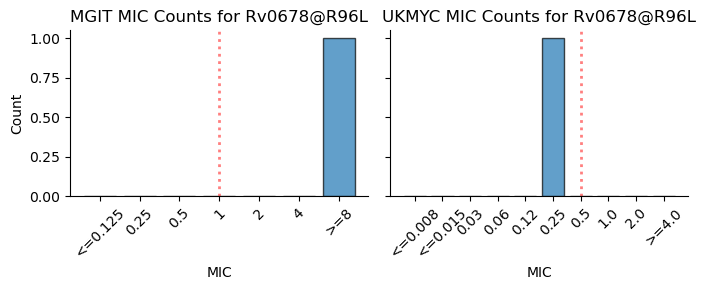

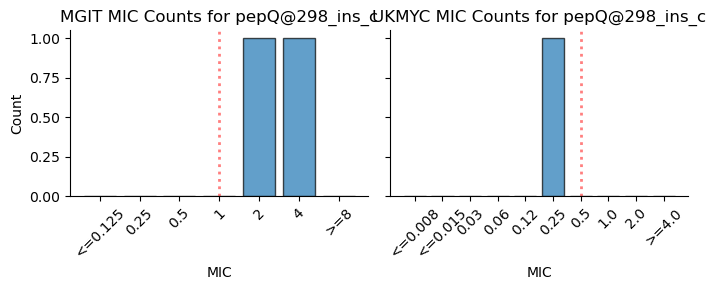

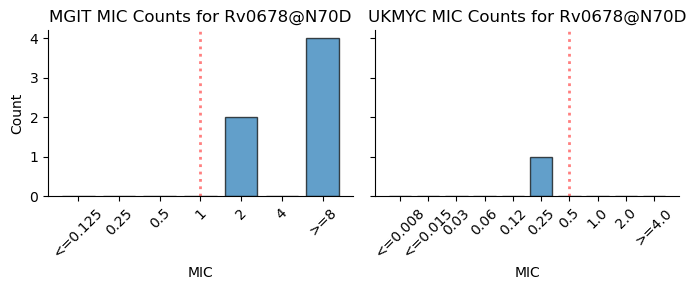

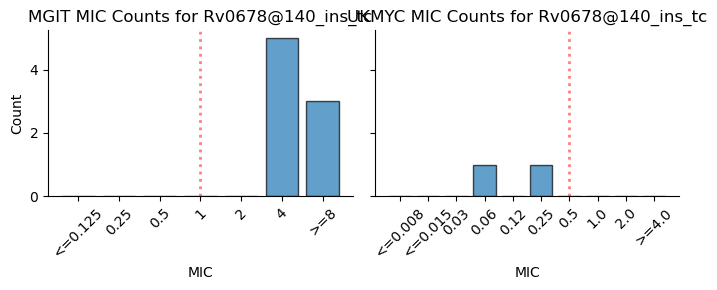

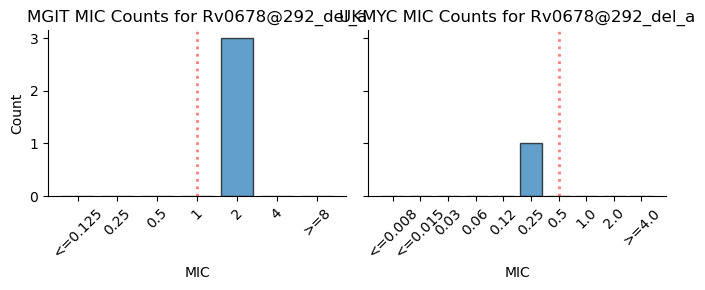

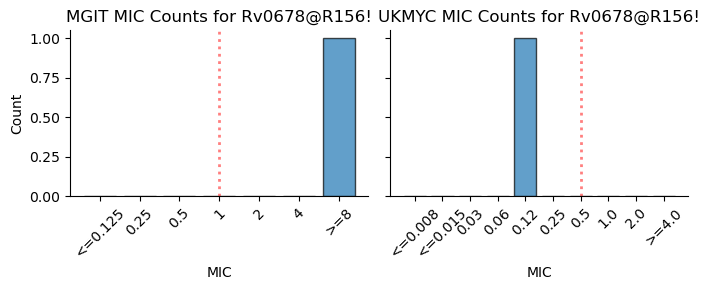

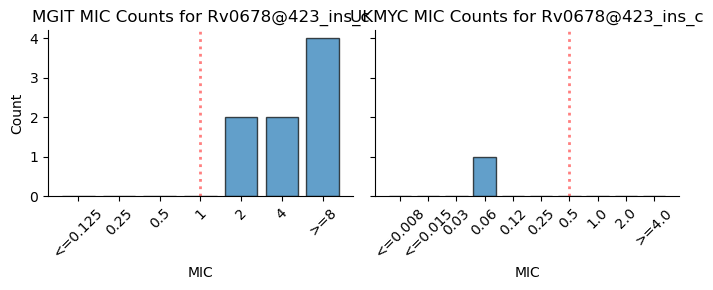

In [10]:
#different phenotyping methods - therefore need different sets of plots. For simplificaion, UKYMC5 and UKYMC6 plates have been combined
joined = pd.merge(samples, mutations, how='left', on=['UNIQUEID'])
joined = joined[(joined.MUTATION.isin(non_zero.keys())) & (joined.UNIQUEID.isin(ids))]

# Define the mic mapping dictionary
nmics = {
    '<=0.008': 0.008,
    '0.12':0.12,
    '0.06':0.06,
    '<=0.015': 0.015,
    '0.03':0.03,
    '1.0':1.0,
    '>1':1.0,
    '0.015':0.015,
    '2': 2.0,
    '0.5': 0.5,
    '<=0.125': 0.125,
    '4': 4.0,
    '8': 8.0,
    '>8': 8.0, 
    '1': 1.0,
    '>2': 2.0, 
    '0.25': 0.25
}

# Map the METHOD_MIC values to numeric
joined['NUMERIC_MIC'] = joined['METHOD_MIC'].apply(lambda mic: nmics[mic] if mic in nmics else np.nan)

# Define consistent bins for the histograms
nicd_bin_labels = ['<=0.125', '0.25', '0.5', '1', '2', '4', '>=8']
nicd_bins = [ 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, np.inf]  # Adjust to include all ranges

other_bin_labels = ['<=0.008', '<=0.015', '0.03', '0.06', '0.12', '0.25', '0.5', '1.0', '2.0', '>=4.0']
other_bins = [0.008, 0.015, 0.03, 0.06, 0.12, 0.25, 0.5, 1.0, 2.0, 4.0, np.inf]

muts = joined['MUTATION'].unique()
#plot nicd and plate mics side by side for each relevant mutations
for mutation in muts:
    subset_nicd = joined[(joined['MUTATION'] == mutation) & (joined['SOURCE'] == 'NICD')]
    subset_not_nicd = joined[(joined['MUTATION'] == mutation) & (joined['SOURCE'] != 'NICD')]
    
    counts_nicd, _ = np.histogram(subset_nicd['NUMERIC_MIC'].dropna(), bins=nicd_bins)
    counts_not_nicd, _ = np.histogram(subset_not_nicd['NUMERIC_MIC'].dropna(), bins=other_bins)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharey=True)
    
    axes[0].bar(nicd_bin_labels, counts_nicd, edgecolor='k', alpha=0.7)
    axes[0].set_title(f'MGIT MIC Counts for {mutation}')
    axes[0].set_xlabel('MIC')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].axvline(x=3, color='red', linestyle='dotted', linewidth=2, alpha=0.5)

    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    
    axes[1].bar(other_bin_labels, counts_not_nicd, edgecolor='k', alpha=0.7)
    axes[1].set_title(f'UKMYC MIC Counts for {mutation}')
    axes[1].set_xlabel('MIC')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].axvline(x=6, color='red', linestyle='dotted', linewidth=2, alpha=0.5)

    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)

    
    plt.tight_layout()
    plt.show()


Okay, this is interesting - the majority of phenotype heterogeneity results from disagreement between the UKMYC MICS and the MGIT MICS - in every case, the MGIT MICs are decidely resistant, while the UKMYC MICs are elevated, but below the ECOFF. This invalidates the hypothesis that MIC distributions are normally distributed over the ECOFF, and rather heterogeneity results from some form of sampling error.

Perhaps we should introduce a minimum sample count threshold, of say 3, to only include variants with some statistical power. This would help deal with the issue of phenotyping disagreement.

## Phenotype Predictions

Now that we have examined the binary phenotype and MIC distributions of heterogenous samples, let's implement a statistical test to provide binary R vs S predictions.

Walker2015 extracts variants that occur in isolation, filters out sample counts lower than 3, and then calls any heterogeneity R and homogenous variant S, and does not use a hypothesis test. Susceptible variants are removed from the dataset and the method repeates until no isolated variants are left.

This implicitly uses a prior assumption that low frequency mutations are probably susceptible, regardless of the size of the confidence interval. This makes sense for essential genes, such as RNA polymerase, where resistance is almost exclusivley conferred by a few, well-defined mutations, and the conditional probability of novel or low-frequency sites raising the MIC is very low.  It also performs particularly well on drugs with bimodal distributions and variants that don't dispaly any phenotype heterogeneity (and where phenotyping methods agree).

However, this is not the case for BDQ. Rv0678, mmpL5, and pepQ are non-essential, and we accordingly observe considerable variance across mutated sites, with many mutations only being observed once (singletons). As variance increases, so does the required amount of data to be confident all resistant sites have been determined. Bedaquiline is a young drug, and we don't have sufficient data at each site to be confident its not resistant.

Therefore, we really need a frequentist hypothesis test rather than a heuristic. For reasons discussed above, a binomial test run on variants in isolation makes more sense. However, the choice of test and test parameters is non-trivial, for example what background rate to use and whether to use a 1-tailed or 2-tailed test.

A 1-tailed test would look for a statistically greater proportion of resistance than background, and variants whose null hypotheses are accepted are classified susceptible. This would not explicitly identify susceptible variants, but rather call any variants susceptible if their confidence limits are below or overlapping the background. Therefore, mutations can be classified susceptible regarldess of statistical power.

In effect, this is not different to the WHOv2's approach of cataloguing mutations with insufficient evidence 'Group 3', and subsequently assuming they are susceptible anyway when making predictions. 

Again, this is justifiable when the conditional probability of novel or low-frequency mutations being resistant is very low. Should the probability of novel mutations being susceptible converge with the probability of variants classified S actually being S, then perhaps, but we don't have the data/statistical power for BDQ and candidate genes are non-essential. 

A 2-tailed test, on the other hand, would 'actively classify' resistant and susceptible variants. The proportion of susceptiblity must be significantly less than background for a susceptible classification. Variants whose null hypotheses are accepted would be deemed 'Unknown'. This makes no assumption of the probability of conferred resistance for novel/low frequency variants, and honestly reports unclassifiable variants - which is in line with the amount of data available.

It would also make S classifications difficult as those variants would require a considerable number of samples - before calling a mutation benign, there must be considerable supporting evidence, which from a clinical standpoint will help minimise the number of very major errors.


In summary, we argue there is an issue of timing with regard to how long the drug has been administerd, and that methods to build catalogues must be tailored to amount of data available, and to the shapes of MIC distributions, as these dictate the validity of underlying assumptions and priors. The idea of one method fits all is outdated, and as long as each method used is reproducible, simple, and well-documented there is no reason to not tailor them.

We recognise a catalogue with few S classifications has limited clinical applicability under our prediction regimen, as samples with any mutations not catalogued as Resistant will all be predicted unknown. In the case of BDQ, we have too much low-frequency variance and not enough data to directly classify susceptible variants or to have a prior to underpin a heuristic - the chance of a novel mutation in Rv0678 conferring susceptiblity is similarly high to it conferring susceptiblity. Therefore, we argue at this stage we can only provide a list of variants that we believe to confer resistance.

#### 2-tailed

Looking for statistically significant S variants is an attractive proposition, as it allows for a degree of certainity regarding both R and S classifications, and an intermediate phenonotype can be introduced; 'Undetermined', for those whose null hypotheses are accepted.

This could be particularly beneficial for this study, as most of our heterogenous samples arise from phenotype disagreements betweent the plate and the MGIT tubes - ie, we don't actually know what the expected phenotype is.


In [26]:
catalogue = BuildCatalogue(
    samples=samples,
    mutations=cat_mutations,
    FRS=0.75,
    seed=["mmpL5@I948V", "mmpL5@T794I"],
    test='Binomial',
    background=0.1,
    tails='two',
    strict_unlock=True
)

catalogue.to_piezo("NC_000962.3", f"BDQ-FRS-75-2024.06", "1.1", "BDQ", piezo_wildcards, outfile='./catalogues/temp/binomial_2_tailed.csv')

print ('catalogue classification counts: \n', catalogue.build_piezo("NC_000962.3", f"BDQ-FRS-75-2024.06", "1.1", "BDQ", piezo_wildcards).PREDICTION.value_counts())


catalogue classification counts: 
 U    431
R     66
S     12
Name: PREDICTION, dtype: int64


Let's see how predictions made off the catalogue look:

[[ 470  308   82]
 [ 224 9935  741]]
Catalogue coverage of isolates: 0.930017006802721
Sensitivity: 0.6041131105398457
Specificity: 0.9779505856875677


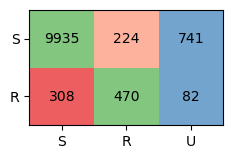

In [28]:
#all.reset_index(inplace=True)
cm, _cov, _sens, _spec, _FN_ids = piezo_predict(all[all.FRS>0.75], f"./catalogues/temp/binomial_2_tailed.csv", "BDQ", Print=True, U_to_S=False)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", 'U'])

utils.plot_truthtables(df_cm)

Despite only having catalogued 12 susceptible variants, and 484 unknowns, we get very decent sensitivity and specificiy.

The majority of susceptible samples contain only mmpL5 seeded mutations or D767 - and once these have been unlocked, there are sufficient solos to classify 70 Resistant variants. 

The limitation of course, is that owing to the 484 unknowns, we cannot classify around 10% of samples.

However, one could argue this statistically strict approach is both optimal and honest - we make no assumptions about samples with little data or those on the edge, and we require a huge amout of 

In [25]:
_sens

0.819538670284939

In [22]:
_spec

0.9843451351597342

In [23]:
_cov

0.9971349119406758

The issue, as discussed above, is S classifications become difficult to make as those variants don't have a high enough count. To make meaningfull S predictions, we would need to introduce additional criteria that don't obey frequentist logic.

#### 1-tailed

A 1-tailed test, on the other hand, won't allow for an intermediate classification but will define susceptibility as 'no evidence for resistance'. This is less satisfactory from a clinical standpoint given our pooled dataset, however it does allow for very simple, legal statistics:

In [14]:
BuildCatalogue(
    samples=samples,
    mutations=cat_mutations,
    FRS=0.1,
    seed=["mmpL5@I948V", "mmpL5@T794I"],
    test='Binomial',
    background=0.1,
    tails='one',
    strict_unlock=True
).to_piezo("NC_000962.3", f"BDQ-FRS-75-2024.06", "1.1", "BDQ", piezo_wildcards, outfile='./catalogues/temp/binomial_3_tailed.csv')


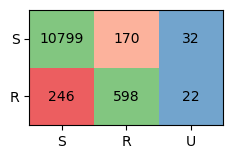

In [15]:
all.reset_index(inplace=True)
cm, _cov, _sens, _spec, _FN_ids = piezo_predict(all, f"./catalogues/temp/binomial_3_tailed.csv", "BDQ", Print=False, U_to_S=False)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", 'U'])

utils.plot_truthtables(df_cm)

In [16]:
df_cm

R      S   U
R  598    246  22
S  170  10799  32

In [31]:
cat_mutations_no_mmpL5 = cat_mutations[~cat_mutations.GENE.isin(['mmpL5', 'mmpS5'])]

BuildCatalogue(
    samples=samples,
    mutations=cat_mutations_no_mmpL5,
    FRS=0.1,
    test='Binomial',
    background=0.2,
    tails='two',
    strict_unlock=True
).to_piezo("NC_000962.3", f"BDQ-FRS-75-2024.06", "1.1", "BDQ", piezo_wildcards, outfile='./catalogues/temp/binomial_7_tailed.csv')

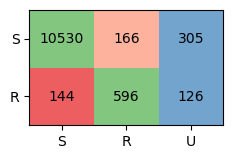

In [32]:
mutations_no_mmpL5 = mutations[~mutations.GENE.isin(['mmpL5', 'mmpS5'])].reset_index()
all_no_mmpL5 = pd.merge(samples, mutations_no_mmpL5,  how='left', on='UNIQUEID')

cm, _cov, _sens, _spec, _FN_ids = piezo_predict(all_no_mmpL5, f"./catalogues/temp/binomial_7_tailed.csv", "BDQ", Print=False, U_to_S=False)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])

utils.plot_truthtables(df_cm)

In [19]:
df_cm

R      S   U
R  611    235  20
S  172  10815  14

TO DO:


Run both a one-tailed and two-tailed Binomial test to show the problem of singletons, and if a 2-tailed test is used we need to add an additional system (ie the homogenous thing), as too many mutations have low statistical power.

Then look at the false negatives of the chosen approach, and see whats going on with them - compare to proportions plot and explain why they're happening.

fyi Have tested lower quality phenotypes - no improvement.

Don't think theres much point trying fisher's - we know what will happen.




Then, need to run Fishers and Binomial tests

Need to try strict_unlock and 1-tailed tests and lower quality phenotypes also. 

Then need to return to manuscript notebook and finish, with the decided protocol from this analysis.

This should all take 2-3 days max.

Then need to update the actual manuscript, and write the talk for Bruges.






In [20]:
joined.METHOD_MIC.unique()

array(['0.5', '0.25', '0.03', '<=0.015', '0.12', '0.06', '0.015',
       '<=0.008', '1.0', '2', '4', nan, '8', '>8'], dtype=object)

Need to also try just looking for difference greater than 0.10 - make it 1 tailed (rather than both ways). It is in essence a more relaxed approach - S's get classified much easier, and only R's need enough data to pass - but, R's get pass the test easily anyway. Rather than the above, where we are saying you have to be damn sure you're correct before calling something S.

With a low background rate, those with large bars that are homogenously susceptible won't pass the test, whilst those that are homogenoulsy resistant will pass. Should we want to capture those susceptible variants that will otherwise be discarded, one could specify only running a test when there is evidence of heterogeneity - ie, their loss could be circumvented by simply not testing.

However, there are heterogenous samples that are unlikely to be statistically different to the bacgkround (calculated or at 0.1).

Let's analyse these: